<a href="https://colab.research.google.com/github/aleena999/wbc_deepLearning/blob/main/ALEXNET_WBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/blood-cells
!unzip /content/blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

In [3]:
# Loading Dataset

train_dir = '/content/dataset2-master/dataset2-master/images/TRAIN'
test_dir = '/content/dataset2-master/dataset2-master/images/TEST'

In [17]:
# Create generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [27]:
# ALEXNET Model

model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


In [30]:
# Model Compilation

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
epochs = 25
stepsperepoch=100
validationsteps=1
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 26, 26, 256)      1024      
 chNormalization)                                                
                                                      

In [31]:
# Model Fitting

hist = model.fit(
    train_images,
    epochs=epochs,
    callbacks=[annealer,es],
    steps_per_epoch=stepsperepoch,
    validation_data=val_images,
)


Epoch 1/25
100/100 [==============================] - 395s 4s/step - loss: 0.8700 - accuracy: 0.6528 - val_loss: 23.4156 - val_accuracy: 0.2624 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - 391s 4s/step - loss: 0.5142 - accuracy: 0.7956 - val_loss: 2.0274 - val_accuracy: 0.6601 - lr: 9.5000e-04
Epoch 3/25
100/100 [==============================] - 392s 4s/step - loss: 0.4681 - accuracy: 0.8219 - val_loss: 1.2035 - val_accuracy: 0.6828 - lr: 9.0250e-04
Epoch 4/25
100/100 [==============================] - 387s 4s/step - loss: 0.2952 - accuracy: 0.8806 - val_loss: 0.6350 - val_accuracy: 0.7833 - lr: 8.5737e-04
Epoch 4: early stopping


In [32]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [34]:

# Model Evaluating

preds = model.evaluate(train_images)
print ("Validation Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))


249/249 [==============================] - 216s 866ms/step - loss: 0.5844 - accuracy: 0.8016
Validation Loss = 0.5844181776046753
Validation Accuracy = 0.8015813231468201


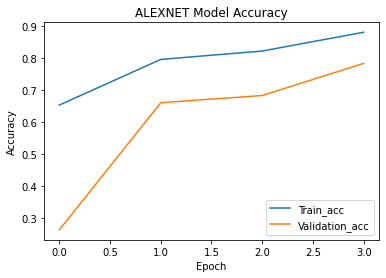

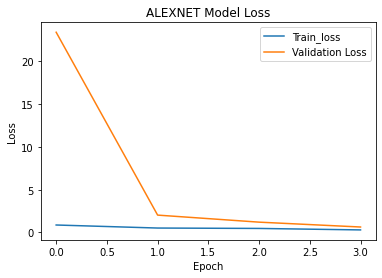

In [35]:

# Plotting Accuracy and Loss

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('ALEXNET Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('ALEXNET Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()


In [37]:

# Classification Report
'''
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(test_images.labels, predictions, target_names=CLASS_NAMES))
'''
predictions = np.argmax(model.predict(test_images), axis=1)
print(classification_report(test_images.labels, predictions, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

  EOSINOPHIL       0.70      0.69      0.69       623
  LYMPHOCYTE       0.99      0.83      0.90       620
    MONOCYTE       0.77      0.33      0.47       620
  NEUTROPHIL       0.46      0.80      0.59       624

    accuracy                           0.66      2487
   macro avg       0.73      0.66      0.66      2487
weighted avg       0.73      0.66      0.66      2487



Test Accuracy: 66.305%


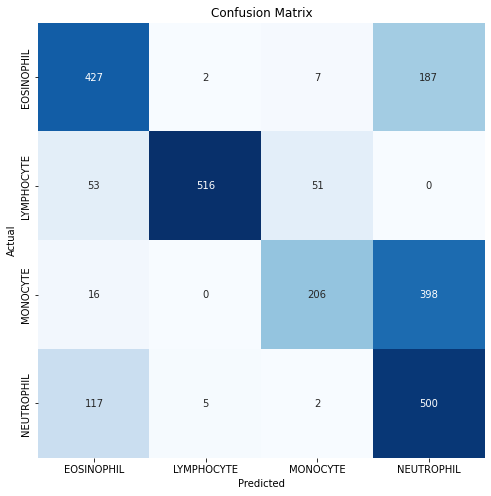

In [39]:
from sklearn.metrics import accuracy_score
import seaborn as sns
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

SOURCE: class: TEST, file: EOSINOPHIL
0
PREDICTED: class: MONOCYTE, confidence: 0.999834


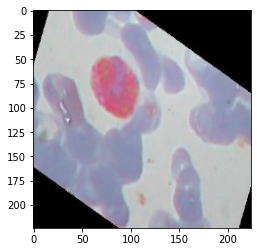

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: LYMPHOCYTE
1
PREDICTED: class: MONOCYTE, confidence: 0.597905


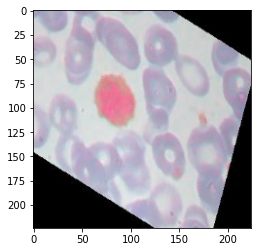

SOURCE: class: TEST, file: NEUTROPHIL
2
PREDICTED: class: NEUTROPHIL, confidence: 0.853327


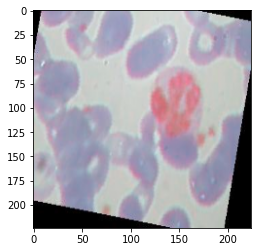

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: MONOCYTE
3
PREDICTED: class: NEUTROPHIL, confidence: 0.530752


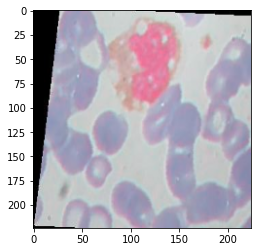

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: EOSINOPHIL
4
PREDICTED: class: MONOCYTE, confidence: 0.572345


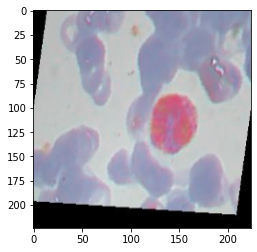

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: NEUTROPHIL
5
PREDICTED: class: NEUTROPHIL, confidence: 0.870651


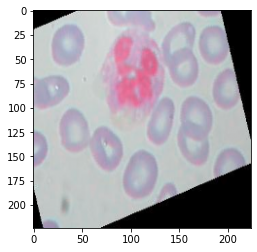

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: NEUTROPHIL
6
PREDICTED: class: NEUTROPHIL, confidence: 0.982713


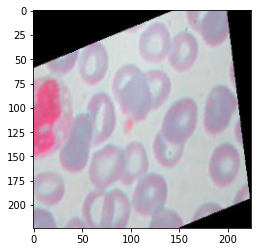

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: LYMPHOCYTE
7
PREDICTED: class: MONOCYTE, confidence: 0.977744


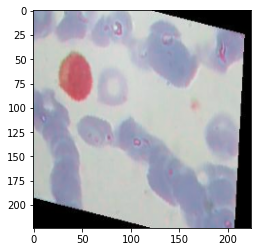

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: EOSINOPHIL
8
PREDICTED: class: NEUTROPHIL, confidence: 0.998607


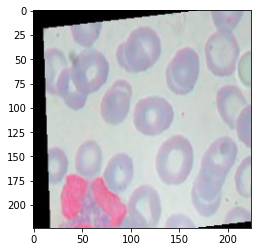

<Figure size 432x288 with 0 Axes>

SOURCE: class: TEST, file: MONOCYTE
9
PREDICTED: class: MONOCYTE, confidence: 0.859085


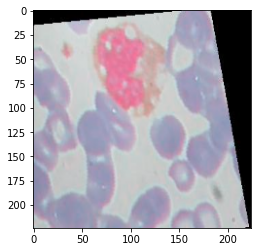

<Figure size 432x288 with 0 Axes>

In [38]:
# Utility
import itertools
import random
from collections import Counter
from glob import iglob
from imutils import paths
import cv2
import os



def load_image(filename):
    img = cv2.imread(os.path.join(test_dir, filename))
    img = cv2.resize(img, (224,224) )
    img = img /255
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {CLASS_NAMES[class_idx]: probabilities[class_idx]}


for idx, filename in enumerate(random.sample(list(paths.list_images(test_dir)),10)):
    print("SOURCE: class: %s, file: %s" % (filename.split('/')[5], filename.split('/')[6]))
    print(idx)
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()